In [105]:

# import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ANN module
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Loss
from sklearn.metrics import mean_squared_error


In [61]:
# current path
current_path = os.getcwd()
print("현재 경로:", current_path)
boston_file_path = '/home/bml_th/code/data/boston.csv'

현재 경로: /home/bml_th/code/test


In [62]:
# load_data
df = pd.read_csv(boston_file_path)
df.rename(columns={'MEDV' : 'Price'}, inplace = True)
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [63]:
## scaling data
from sklearn.preprocessing import MinMaxScaler
# features data to numpy array
X = df.drop('Price', axis = 1).to_numpy()
y = df['Price'].to_numpy().reshape((-1, 1))

# scaling
# MinMax Scaling => ((X-min(X))/(max(X)-min(X)) 
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
scaler.fit(y)
y = scaler.transform(y)

X.shape, y.shape

((506, 13), (506, 1))

In [64]:
# torch의 Datasets 상속
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.

class TensorData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

In [65]:
# split train/test data (50:50)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# create batch type of train and test data
trainsets = TensorData(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size = 32, shuffle = True) # DataLoader: 학습할 데이터셋을 쪼개서, 미니 배치 단위로 모델에 입력.

testsets = TensorData(X_test, y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size = 32, shuffle = True) # DataLoader: 학습할 데이터셋을 쪼개서, 미니 배치 단위로 모델에 입력.

In [96]:
# Model
from torch import nn, optim                           # torch 에서 제공하는 신경망 기술, 손실함수, 최적화를 할 수 있는 함수들을 불러온다.
import torch.nn.functional as F                       # torch 내의 세부적인 기능을 불러옴.

input_n = X_train.shape[1]
output_n = y_train.shape[1]

class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(input_n, 50, bias = True) # input layer(13) -> hidden layer1(50)
        self.fc2 = nn.Linear(50, 30, bias = True) # hidden layer1(50) -> hidden layer2(30)
        self.fc3 = nn.Linear(30, output_n, bias = True) # hidden layer2(30) -> ouput layer(1)
        self.dropout = nn.Dropout(0.2) # randomly dropout nodes 2%

    def forward(self, x): # 모델 연산 순서 정의
        x = F.relu(self.fc1(x)) # activation function: relu
        x = self.dropout(F.relu(self.fc2(x))) # dropout in hidden layer2 -> 30 * 0.2 = 6 nodes droupout
        x = F.relu(self.fc3(x)) # activation function: relu
        return x
    
# drop-out: 특정한 설명변수 feature만을 과도하게 집중하여 학습함으로써 발생할 수 있는 overfitting을 방지하기 위해 사용하는 기법.

In [99]:
# model, loss_function, optimization 선언
model = Regressor() 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-7)

In [100]:
# trianing
loss_ = [] # loss list
n = len(trainloader) # iteration(8) = train_size/batch_size

for epoch in range(400):
    running_loss = 0.0 # 각 배치마다(iteration) 나오는 loss로부터 MSE를 구하기 위해서 사용.

    for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
        inputs, values = data # data에는 X, Y가 들어있음.
        optimizer.zero_grad() # 최적화 초기화
        outputs = model(inputs) # 모델에 입력값을 넣어 예측값 계산
        loss = criterion(outputs, values) # 손실함수를 계산, error계산
        loss.backward() # 손실함수를 기준으로 역전파를 설정한다.
        optimizer.step() # 역전파를 진행하고 가중치를 업데이트

        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
    
    loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

        

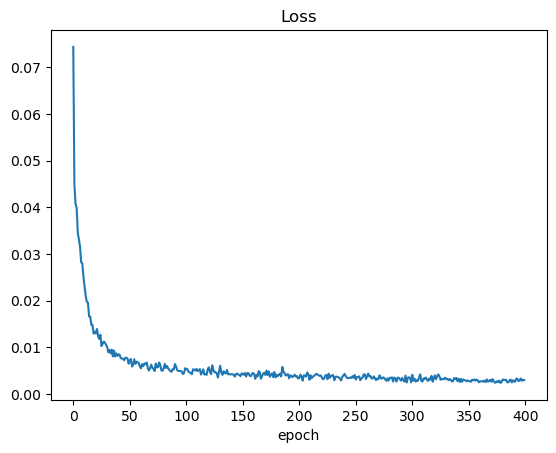

In [101]:
# plot loss
plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [104]:
# evaluation test set

def evaluation(dataloader):
    predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서
    actual = torch.tensor([], dtype = torch.float) # 실제값을 저장하는 텐서
    
    with torch.no_grad():
        model.eval() # evaluation model

        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0) # cat 함수를 통해 예측값을 누적.
            actual = torch.cat((actual, values), 0)

    predictions = predictions.numpy() # 넘파이 배열로 변경.
    actual = actual.numpy() # 넘파이 배열로 변경.
    print('predictions_shape:', predictions.shape)
    print('actual_shape:', actual.shape)

    rmse = np.sqrt(mean_squared_error(predictions, actual))
    return rmse

train_rmse = evaluation(trainloader)
print(f'train rmse:{train_rmse}')

# test
test_rmse = evaluation(testloader)
print(f'test rmse:{test_rmse}')

predictions_shape: (253, 1)
actual_shape: (253, 1)
train rmse:0.04196630045771599
predictions_shape: (253, 1)
actual_shape: (253, 1)
test rmse:0.08417942374944687
